In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer

import spacy
nlp = spacy.load('en_core_web_sm')
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from yellowbrick.text import FreqDistVisualizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

#import dataframe_image as dfi

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'E:\C.TSUBASA\DATA SCIENCE\DATA\wiki_movie_plots_deduped.csv')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [5]:
df.describe(include='object').T

,count,unique,top,freq
Title,34886,32432,Cinderella,8
Origin/Ethnicity,34886,24,American,17377
Director,34886,12593,Unknown,1124
Cast,33464,32182,Tom and Jerry,80
Genre,34886,2265,unknown,6083
Wiki Page,34886,34070,https://en.wikipedia.org/wiki/Digimon_Adventur...,5
Plot,34886,33869,"(マッスル人参争奪！超人大戦争, Massuru Ninjin Soudatsu! Chou...",6


In [6]:
df.isnull().sum()

Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64

### EDA

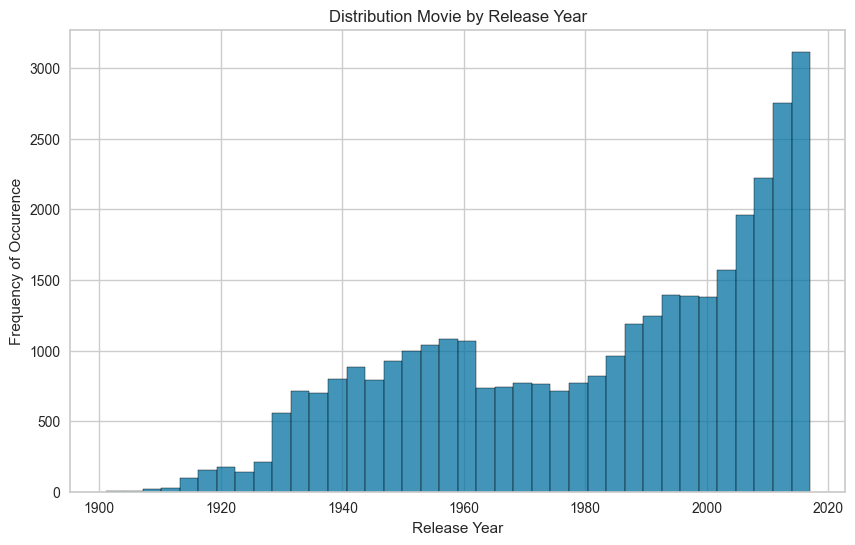

In [7]:
plt.figure(figsize=(10,6))
sns.histplot(df['Release Year'])
plt.title('Distribution Movie by Release Year')
plt.ylabel('Frequency of Occurence')
plt.show()

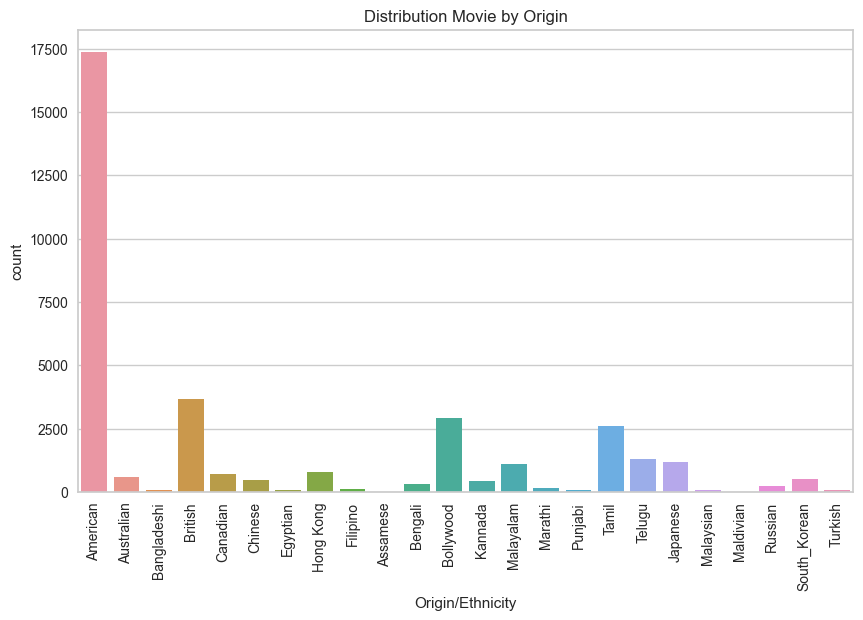

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Origin/Ethnicity')
plt.xticks(rotation=90)
plt.title('Distribution Movie by Origin');


In [9]:
# resetting datasets only include a known genre then resetting index
df = df[df['Genre'] != 'unknown'].reset_index(drop=True)

In [10]:
df['Genre'].value_counts().nlargest(10)

drama        5964
comedy       4379
horror       1167
action       1098
thriller      966
romance       923
western       865
crime         568
adventure     526
musical       467
Name: Genre, dtype: int64

<BarContainer object of 6 artists>

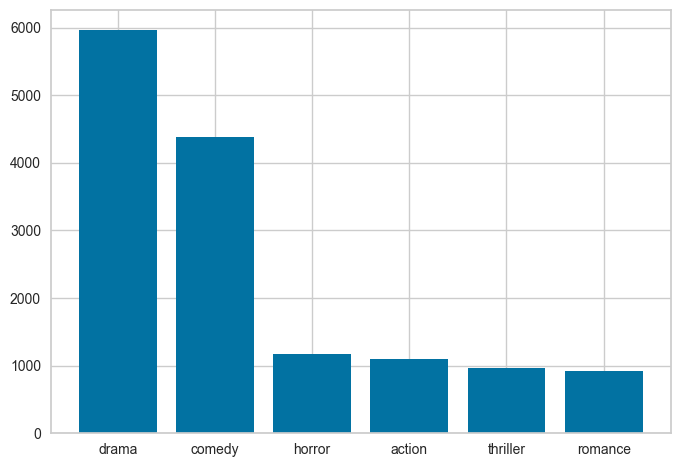

In [11]:
top_6_genre = df['Genre'].value_counts().nlargest(6)
df_top_6 = df[df['Genre'].isin(top_6_genre.index)]

plt.bar(top_6_genre.index, top_6_genre.values)


<AxesSubplot: xlabel='Genre', ylabel='count'>

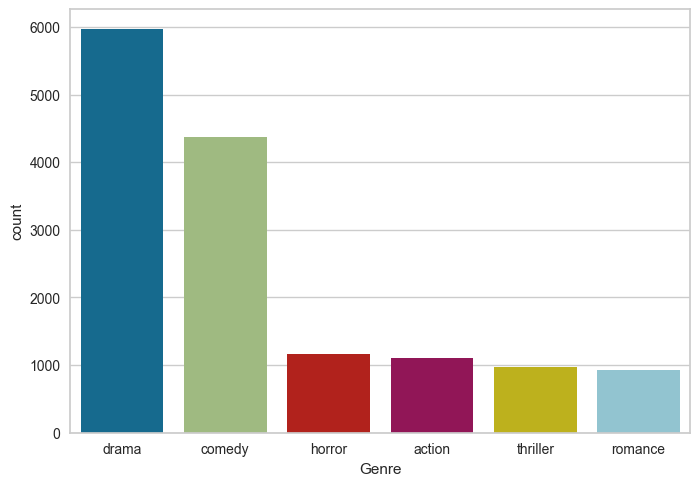

In [12]:
sns.countplot(data=df, x='Genre', order=top_6_genre.index)


In [13]:
genres = {'drama' : 1, 'comedy' : 2, 'horror' :3, 'action' : 4, 'thriller' : 5, 'romance':6}
df['label'] = df['Genre'].map(genres).fillna(0)

conditions = [df['Genre']=='drama', df['Genre']=='comedy', df['Genre']=='horror', df['Genre']=='action', df['Genre']=='thriller',
             df['Genre']=='romance']
choices = [1,2,3,4,5,6]
df['labels'] = np.select(conditions, choices, 0)

In [14]:
df.sample(3)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,label
13847,2003,Bells of Innocence,American,Alin Bijan,"Mike Norris, Marshall R. Teague, Chuck Norris",horror,https://en.wikipedia.org/wiki/Bells_of_Innocence,Jux Jonas (Mike Norris) is a man whose faith i...,3.0
15383,2009,Spread,American,David Mackenzie,"Ashton Kutcher, Anne Heche, Margarita Levieva,...",comedy,https://en.wikipedia.org/wiki/Spread_(film),Narcissistic gigolo Nikki (Ashton Kutcher) liv...,2.0
25930,2011,Jihne Mera Dil Luteya,Punjabi,Mandeep Kumar,"Diljit Dosanjh, Gippy Grewal, Neeru Bajwa, Dee...",romantic comedy,https://en.wikipedia.org/wiki/Jihne_Mera_Dil_L...,Life is carefree and filled with series of mis...,0.0


In [15]:
df.label.value_counts()

0.0    14306
1.0     5964
2.0     4379
3.0     1167
4.0     1098
5.0      966
6.0      923
Name: label, dtype: int64

In [16]:
# resetting dataset frame to only include rows (1-6) label
df = (df.loc[df['label'] !=0].reset_index(drop=True))
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,label
0,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,2.0
1,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,2.0
2,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,2.0
3,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,1.0
4,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,1.0


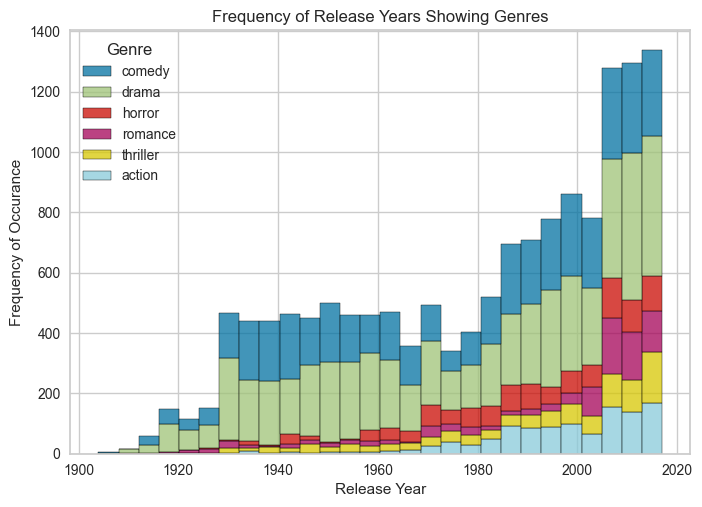

In [17]:
sns.histplot(x='Release Year', hue='Genre', data=df, multiple='stack')
plt.xlabel('Release Year')
plt.ylabel('Frequency of Occurance')
plt.title('Frequency of Release Years Showing Genres')
plt.show()

In [18]:
#Dropping Unnecessary cols
df.drop(columns=['Release Year','Origin/Ethnicity','Director','Cast','Wiki Page'], axis=1, inplace=True)
df.head()

,Title,Genre,Plot,label
0,The Suburbanite,comedy,The film is about a family who move to the sub...,2.0
1,How Brown Saw the Baseball Game,comedy,Before heading out to a baseball game at a nea...,2.0
2,Laughing Gas,comedy,The plot is that of a black woman going to the...,2.0
3,The Adventures of Dollie,drama,On a beautiful summer day a father and mother ...,1.0
4,The Black Viper,drama,A thug accosts a girl as she leaves her workpl...,1.0


In [19]:
df['Plot'][1]

"Before heading out to a baseball game at a nearby ballpark, sports fan Mr. Brown drinks several highball cocktails. He arrives at the ballpark to watch the game, but has become so inebriated that the game appears to him in reverse, with the players running the bases backwards and the baseball flying back into the pitcher's hand. After the game is over, Mr. Brown is escorted home by one of his friends. When they arrive at Brown's house, they encounter his wife who becomes furious with the friend and proceeds to physically assault him, believing he is responsible for her husband's severe intoxication.[1]"

In [20]:
#Total number of words in the plot summaries
def word_length(text):
    num_of_words = 0
    for row in text:
        words = [word for word in row.split(' ')]
        num_of_words += len(words)
    return num_of_words

raw_length = word_length(df['Plot'])

In [21]:
def unique_word_length(text):
    unique_words = set()
    for row in text:
        words = [word for word in row.split(' ')]
        unique_words.update(words)
    return len(unique_words)

raw_length_unique = unique_word_length(df['Plot'])

In [22]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['one','two','go','goes','get','also','however','tells']
stopwords_list += [0,1,2,3,4,5,6,7,8,9]


def clean_text(text):
    text = text.lower()
    text = re.sub(r"\'s|\'ve|n't|\'re|\'d|\'ll|'scuse", lambda match: ' ' + match.group().replace("'", "") + ' ', text)
    text = re.sub('\W|\d+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = word_tokenize(text)
    text = [w.lemma_ for w in nlp(' '.join(text))]
    text = [w for w in text if w not in stopwords_list]
    text = ' '.join(text)
    return text

In [23]:
# Rechecking the summary we looked at above to see if our function worked
new_df = df.copy(deep=True)

new_df['Plot'] = new_df['Plot'].map(lambda x: clean_text(x))
new_df['Plot'][5]

'young couple decide elope catch midst romantic moment woman angry father make plan leave thief discover plan hide trunk wait right moment steal belonging'

In [24]:
clean_length = word_length(new_df['Plot'])
clean_unique_length = unique_word_length(new_df['Plot'])    

In [25]:
plot_length = [[raw_length, clean_length], [raw_length_unique, clean_unique_length]]
length_df = pd.DataFrame(plot_length, columns=['num_of_words', 'num_of_unique_words'])
length_df['index'] = ['raw_plot', 'cleaned_plot']

y1 = length_df['num_of_words']
y2 = length_df['num_of_unique_words']

In [26]:
length_df

,num_of_words,num_of_unique_words,index
0,5240143,2867302,raw_plot
1,253147,70644,cleaned_plot


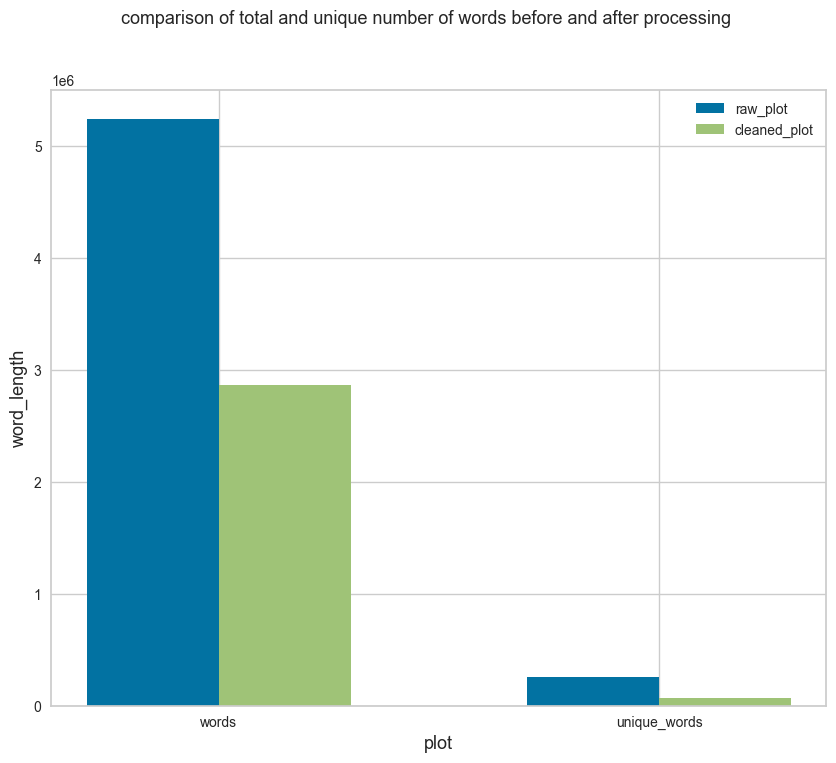

In [27]:
plt.figure(figsize=(10,8))
ind= np.arange(2)
width =0.3

plt.bar(ind, y1, width, label='raw_plot')
plt.bar(ind + width, y2, width, label='cleaned_plot')
plt.xlabel('plot', size=13)
plt.ylabel('word_length', size=13)
plt.suptitle('comparison of total and unique number of words before and after processing', size=13)
plt.xticks(ind + width /2, ('words', 'unique_words'))
plt.legend(loc='best')
plt.show()


### Distribution of words in plot and movie title for each genre
Drama

Lets see most common word show in this dataset

In [28]:
import itertools

In [29]:
drama_plot = new_df.loc[new_df['label'] == 1, ['Plot','Title']]
drama_plot_list = [x for x in drama_plot['Plot'].str.split()]
drama_plot_list = list(itertools.chain(*drama_plot_list))

count = CountVectorizer()
doc = count.fit_transform(drama_plot_list)
features = count.get_feature_names_out()


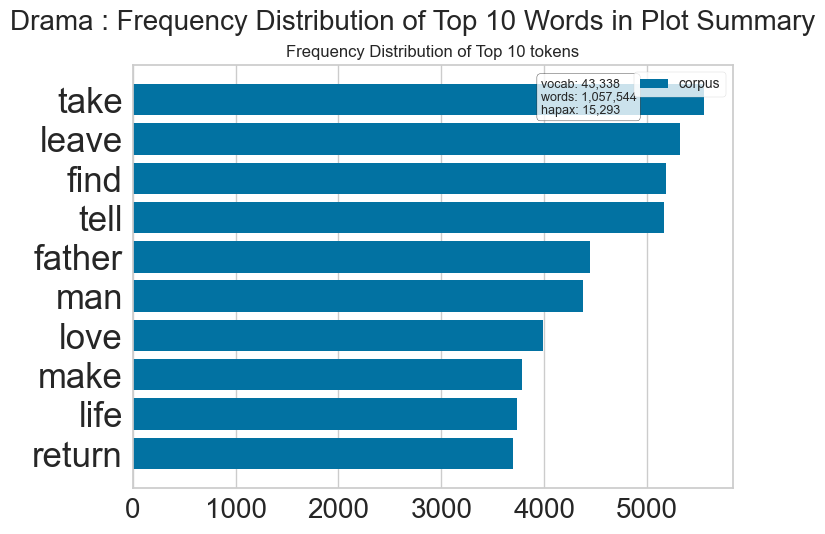

In [30]:
plt.suptitle('Drama : Frequency Distribution of Top 10 Words in Plot Summary', size=20)
plt.yticks(fontsize=25)
plt.xticks(fontsize=20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features= features, n=10, orient='h')
visualizer.fit(doc)
visualizer.show();


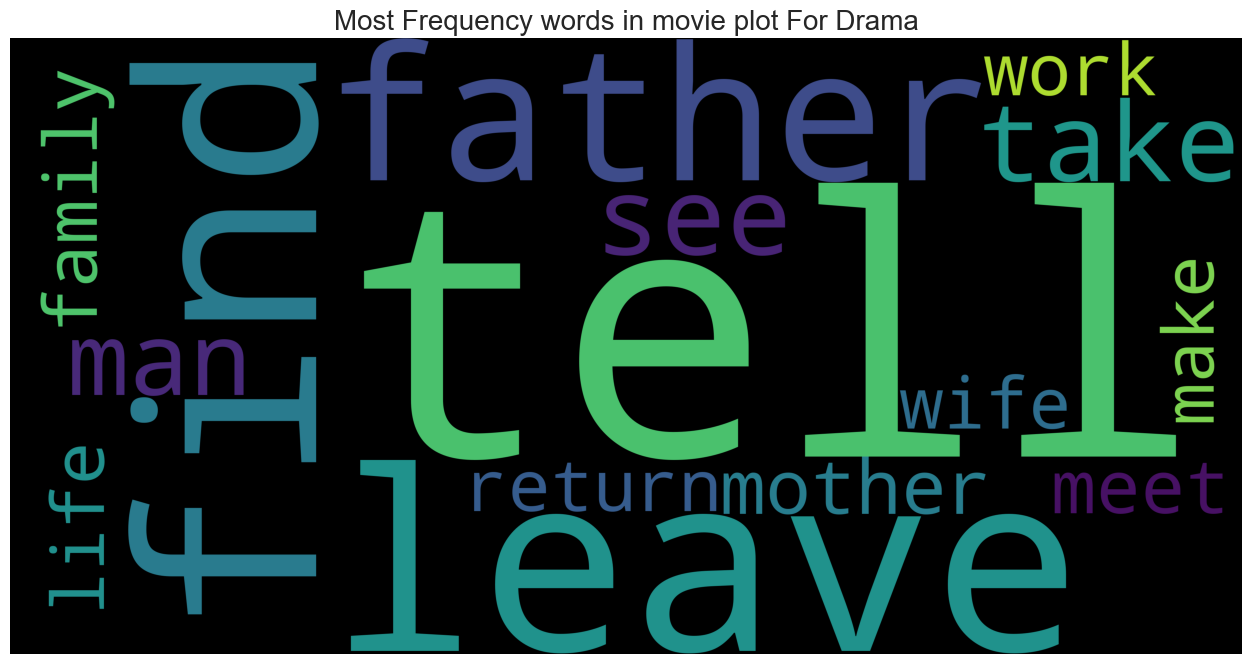

In [31]:
# Lets doing with wordcloud
plot_corpus = ' '.join(drama_plot_list)
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words=15, height=2000, width=4000, normalize_plurals=False).generate(plot_corpus)

plt.figure(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequency words in movie plot For Drama', fontsize=20)
plt.show()

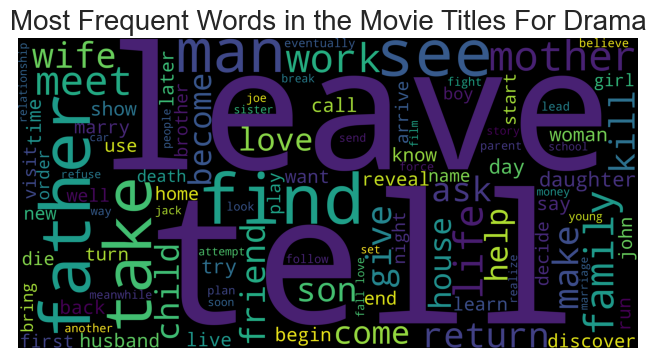

In [32]:
title_corpus = ' '.join(drama_plot_list)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black',
                            height=2000, 
                            width=4000, 
                            random_state = 42, 
                            max_words = 100).generate(title_corpus)

plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Drama', fontsize = 20)
plt.show()

COMEDY

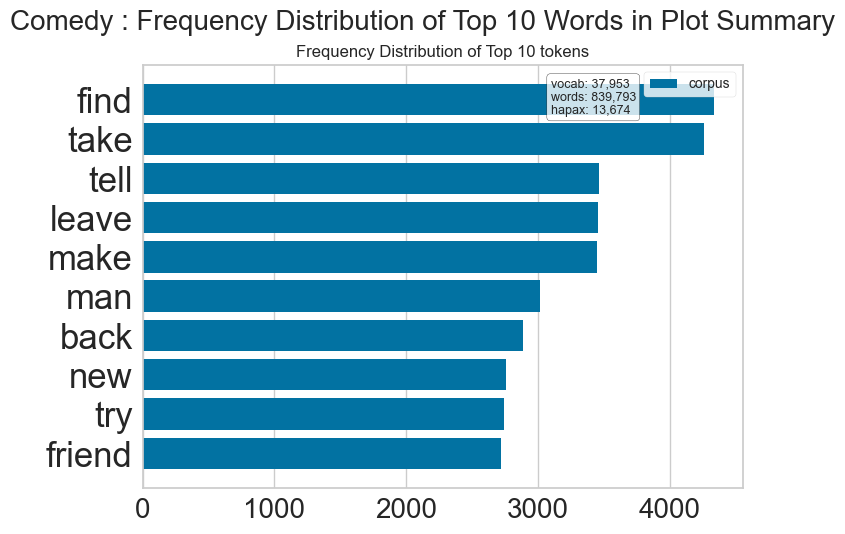

In [33]:
comedy_plot = new_df.loc[new_df['label'] == 2, ['Plot','Title']]
comedy_plot_list = [x for x in comedy_plot['Plot'].str.split()]
comedy_plot_list = list(itertools.chain(*comedy_plot_list))

count = CountVectorizer()
docs = count.fit_transform(comedy_plot_list)
features = count.get_feature_names_out()

plt.suptitle('Comedy : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features=features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show();

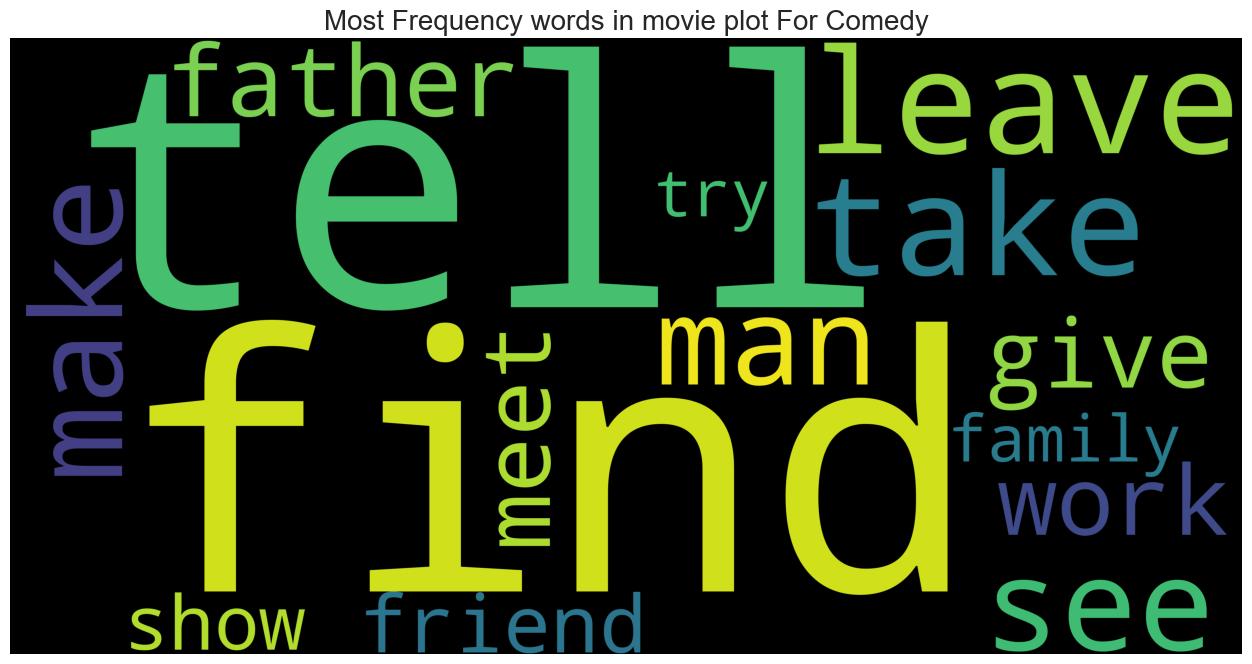

In [34]:
# Lets doing with wordcloud
plot_corpus = ' '.join(comedy_plot_list)
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words=15, height=2000, width=4000, normalize_plurals=False).generate(plot_corpus)

plt.figure(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequency words in movie plot For Comedy', fontsize=20)
plt.show()

Horror

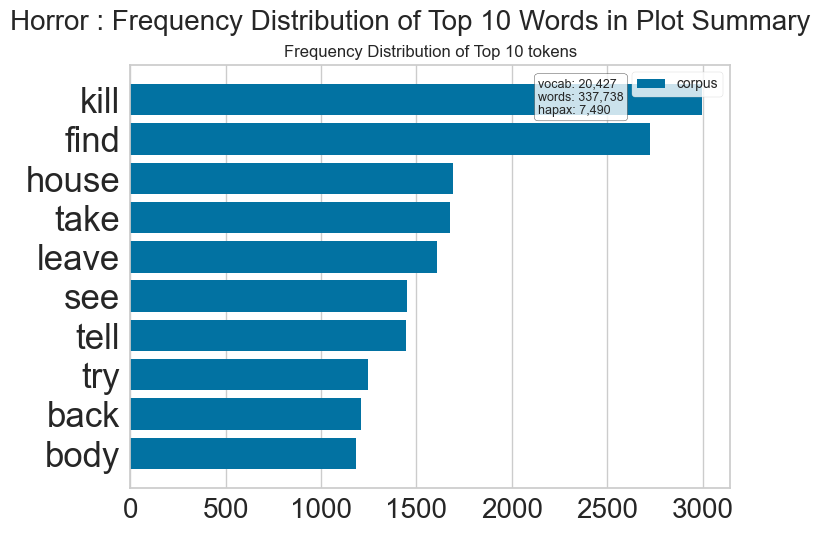

In [35]:
horror_plot = new_df.loc[new_df['label'] == 3, ['Plot','Title']]
horror_plot_list = [x for x in horror_plot['Plot'].str.split()]
horror_plot_list = list(itertools.chain(*horror_plot_list))

count = CountVectorizer()
docs = count.fit_transform(horror_plot_list)
features = count.get_feature_names_out()

plt.suptitle('Horror : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features=features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show();

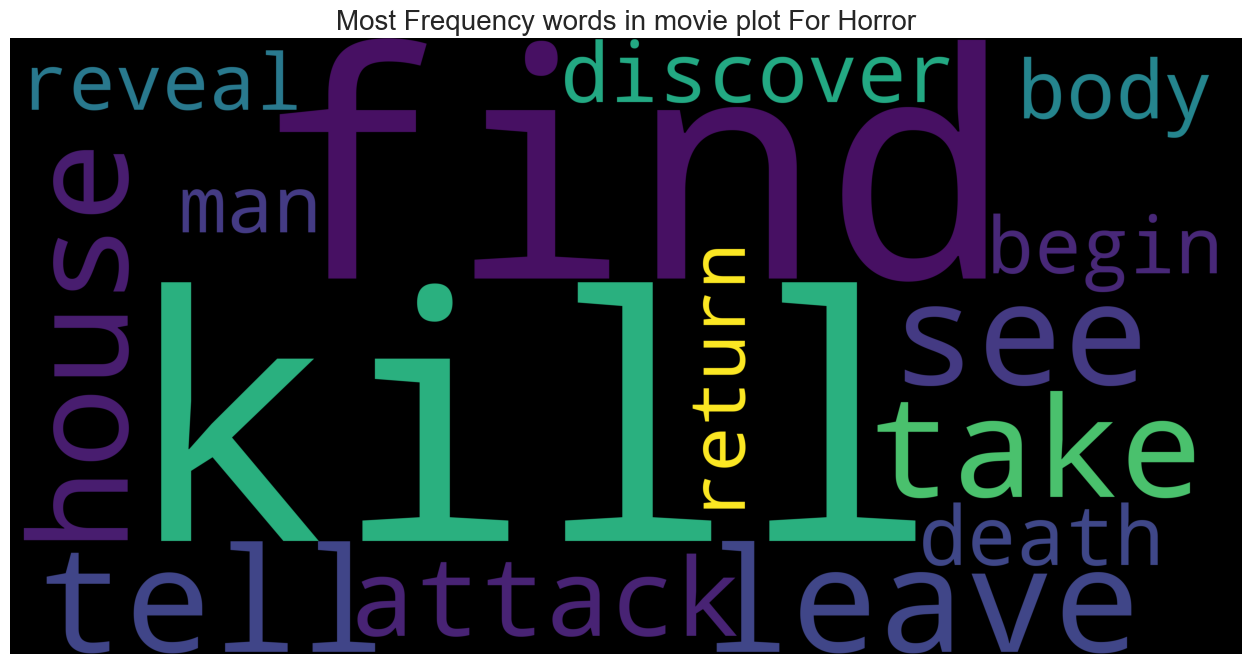

In [36]:
# Lets doing with wordcloud
plot_corpus = ' '.join(horror_plot_list)
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words=15, height=2000, width=4000, normalize_plurals=False).generate(plot_corpus)

plt.figure(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequency words in movie plot For Horror', fontsize=20);

ACTION

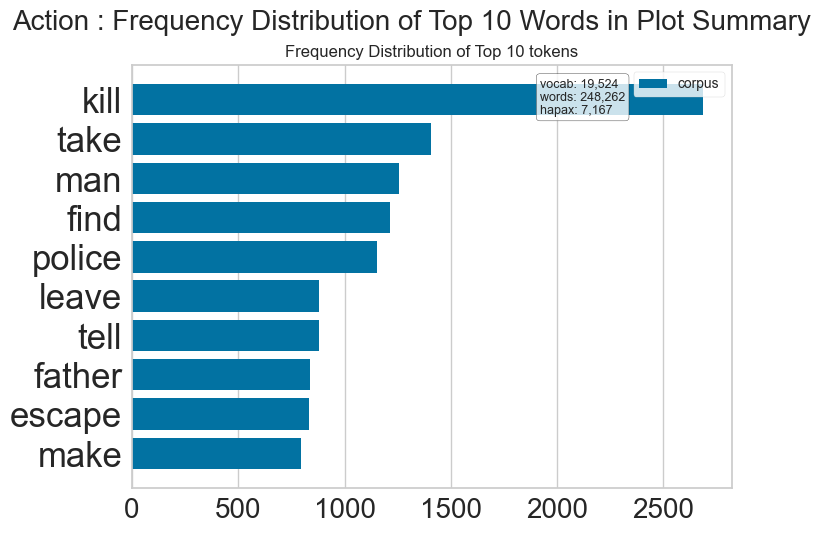

In [37]:
action_plot = new_df.loc[new_df['label'] == 4, ['Plot','Title']]
action_plot_list = [x for x in action_plot['Plot'].str.split()]
action_plot_list = list(itertools.chain(*action_plot_list))

count = CountVectorizer()
docs = count.fit_transform(action_plot_list)
features = count.get_feature_names_out()

plt.suptitle('Action : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features=features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show();

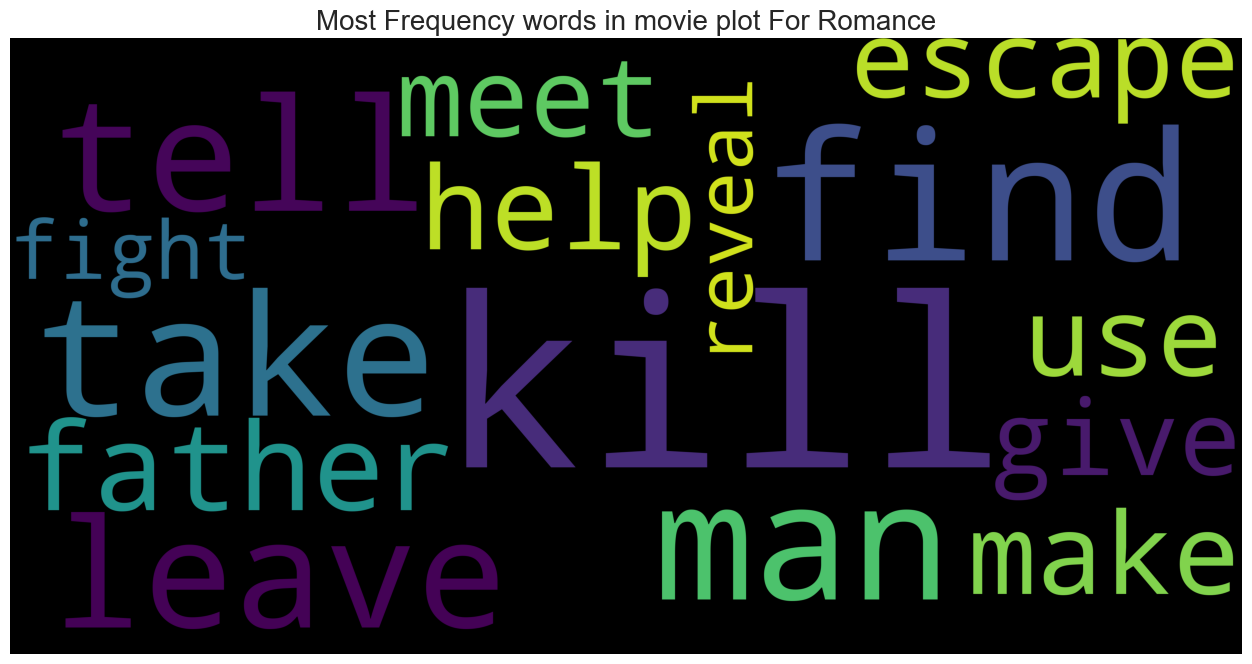

In [38]:
# Lets doing with wordcloud
plot_corpus = ' '.join(action_plot_list)
plot_wordcloud = WordCloud(stopwords=STOPWORDS,
                            background_color='black',
                            max_words=15, height=2000,
                            width=4000, normalize_plurals=False).generate(plot_corpus)

plt.figure(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequency words in movie plot For Romance', fontsize=20)
plt.show()

THRILLER

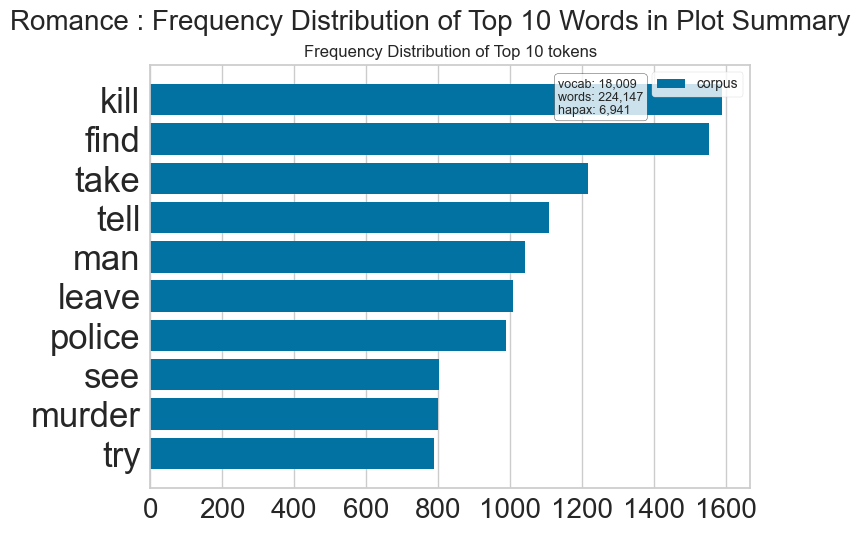

In [39]:
thriller_plot = new_df.loc[new_df['label'] == 5, ['Plot','Title']]
thriller_plot_list = [x for x in thriller_plot['Plot'].str.split()]
thriller_plot_list = list(itertools.chain(*thriller_plot_list))

count = CountVectorizer()
doc = count.fit_transform(thriller_plot_list)
features = count.get_feature_names_out()

plt.suptitle('Romance : Frequency Distribution of Top 10 Words in Plot Summary', size=20)
plt.yticks(fontsize=25)
plt.xticks(fontsize=20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features= features, n=10, orient='h')
visualizer.fit(doc)
visualizer.show();


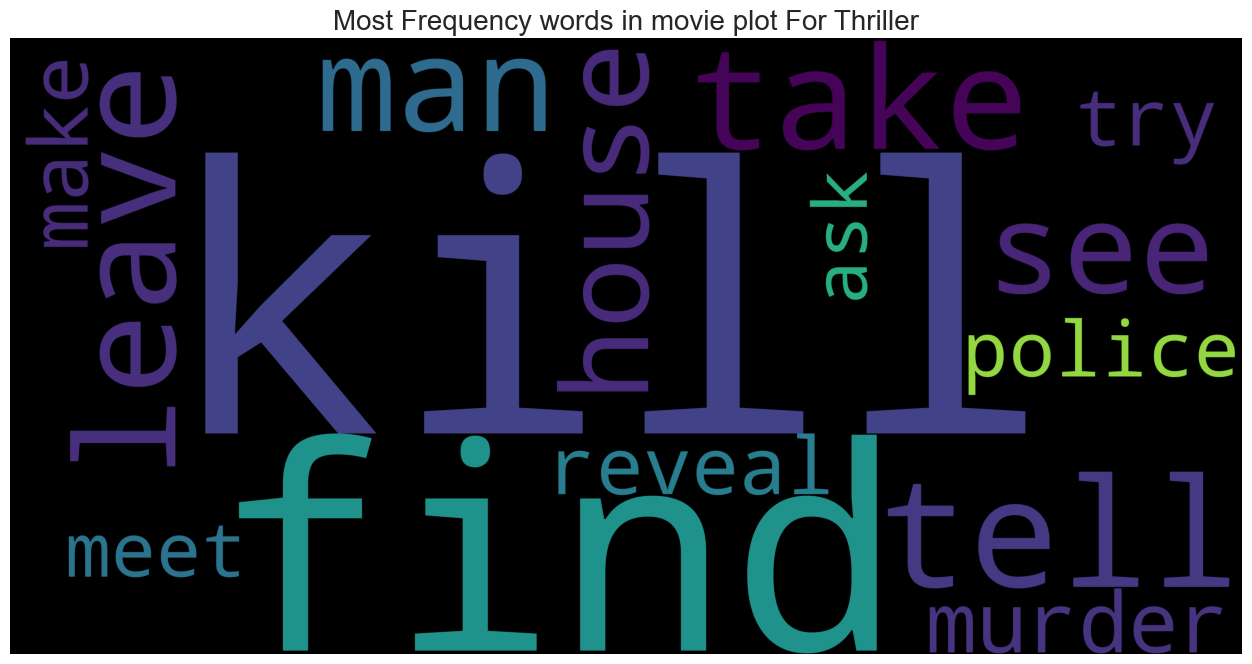

In [40]:
# Lets doing with wordcloud
plot_corpus = ' '.join(thriller_plot_list)
plot_wordcloud = WordCloud(stopwords=STOPWORDS,
                            background_color='black',
                            max_words=15, height=2000,
                            width=4000, normalize_plurals=False).generate(plot_corpus)

plt.figure(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequency words in movie plot For Thriller', fontsize=20)
plt.show()

Romance

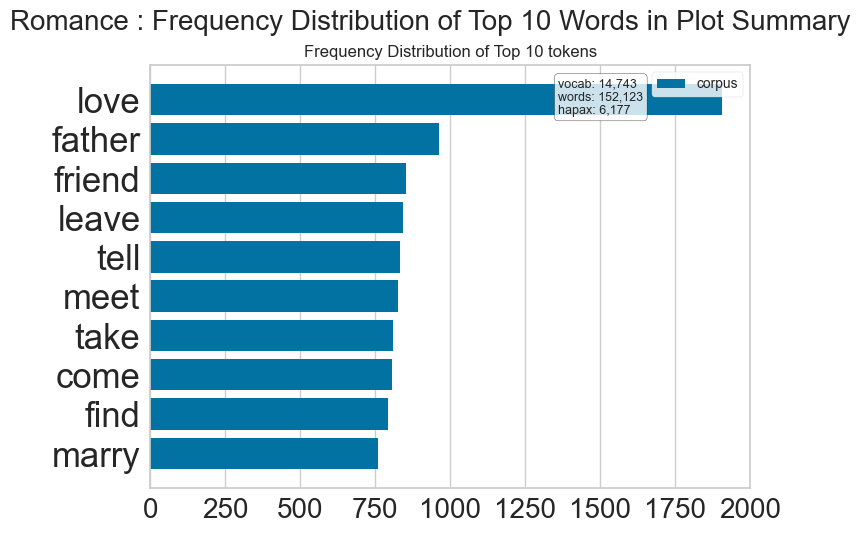

In [41]:
romance_plot = new_df.loc[new_df['label'] == 6, ['Plot','Title']]
romance_plot_list = [x for x in romance_plot['Plot'].str.split()]
romance_plot_list = list(itertools.chain(*romance_plot_list))

count = CountVectorizer()
doc = count.fit_transform(romance_plot_list)
features = count.get_feature_names_out()

plt.suptitle('Romance : Frequency Distribution of Top 10 Words in Plot Summary', size=20)
plt.yticks(fontsize=25)
plt.xticks(fontsize=20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features= features, n=10, orient='h')
visualizer.fit(doc)
visualizer.show();


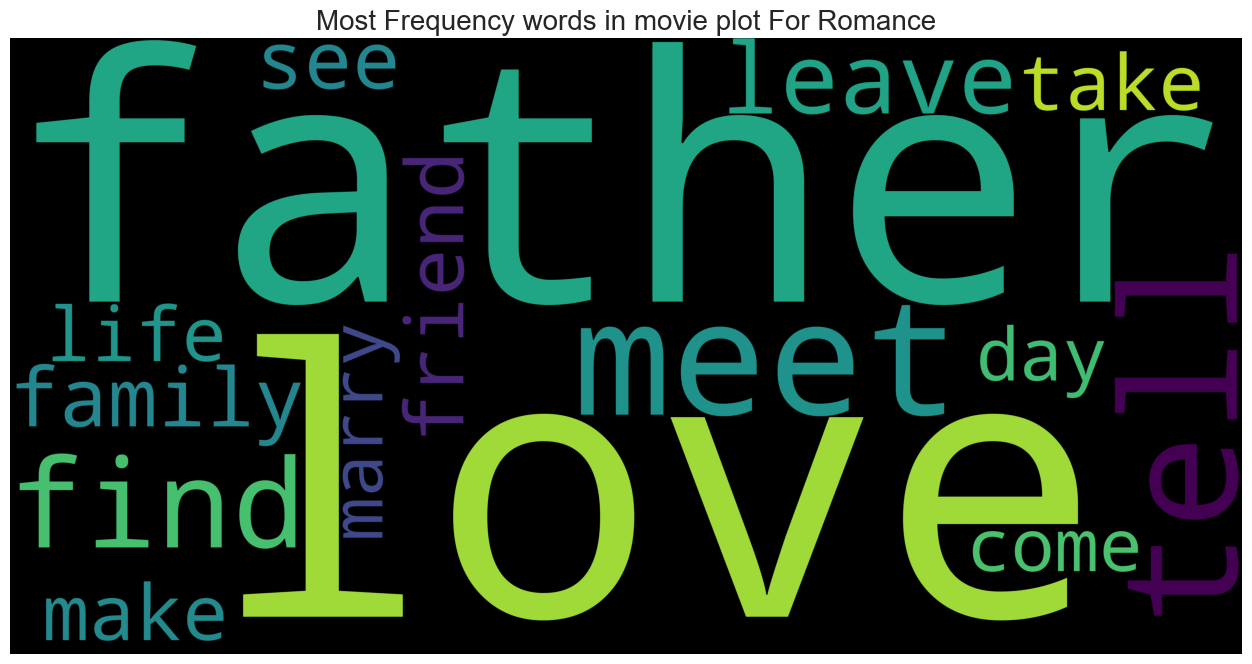

In [42]:
# Lets doing with wordcloud
plot_corpus = ' '.join(romance_plot_list)
plot_wordcloud = WordCloud(stopwords=STOPWORDS,
                            background_color='black',
                            max_words=15, height=2000,
                            width=4000, normalize_plurals=False).generate(plot_corpus)

plt.figure(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequency words in movie plot For Romance', fontsize=20)
plt.show()

MODELLING

Split Dataset

In [43]:
X = new_df['Plot']
y = new_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### Using TfidfVectorizer

In [44]:
vectorizer = TfidfVectorizer(ngram_range= (1,1), max_df=.85, min_df=15, lowercase=False)
Tfidf_X = vectorizer.fit_transform(X_train)

In [45]:
'''Hyperparameter Tuning'''
def rs_cv_sc(model, parameters, X_train, X_test, y_train, y_test):
    np.random.seed(42)

    mrbs = {}
    mrps = {}

    for name, m in model.items():
        rs_model = GridSearchCV(m, param_grid=parameters[name], cv=5, verbose=1)
        rs_model.fit(X_train, y_train)
        mrbs[name] = rs_model.best_score_
        mrps[name] = rs_model.best_params_

    return mrbs, mrps

In [46]:
params = {'MultinomialNB' : {'alpha': [0, 0.2, 0.5, 0.8, 1.0],
                             'fit_prior': [True, False],
                             'class_prior': [None, [.4, .3, 0.08, .07, .06, .06], [.167, .167, .167, .167, .167, .167]]
                             },
         'LogisticRegression' : {'penalty' : ['l1', 'l2', 'none'],
                                 'C' : [1.0, 1e2, 1e4, 1e10],
                                 'class_weight' : ['balanced',None],
                                 'solver' : ['lbfgs', 'liblinear'],
                                 'multi_class': ['over','multinomial']
                                 },
      'DecisionTreeClassifier' : {'criterion' : ['gini', 'entropy'],
                                  'max_depth' : [1,2,5,10],
                                  'min_samples_split' : [1,5,10,20]
                                  },
      'RandomForestClassifier' : {'n_estimators' : [100,200,500],
                                  'criterion' : ['gini', 'entropy'],
                                  'max_depth' : [None, 10,20],
                                  'min_samples_split' : [2,5,10],
                                  'min_samples_leaf' : [1,2,4],
                                  'max_features' : ['auto','sqrt','log2']
                                  }
          }



models = {
    'MultinomialNB' : MultinomialNB(),
    'LogisticRegression' : LogisticRegression(),
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'RandomForestClassifier' : RandomForestClassifier()
}

In [ ]:
mrs, mrbs = rs_cv_sc(models, params, Tfidf_X, X_test, y_train, y_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


In [49]:
import joblib 
#joblib.dump(mrs, 'mrs.pkl')
#joblib.dump(mrbs, 'mrbs.pkl')


mrs = joblib.load('mrs.pkl')
mrbs = joblib.load('mrbs.pkl')


In [50]:
mrs

{'MultinomialNB': 0.6166309044189957,
 'LogisticRegression': 0.6249087544544196,
 'DecisionTreeClassifier': 0.4644966109401601,
 'RandomForestClassifier': 0.5654905095750193}

In [51]:
mrbs

{'MultinomialNB': {'alpha': 0.8, 'class_prior': None, 'fit_prior': False},
 'LogisticRegression': {'C': 1.0,
  'class_weight': None,
  'multi_class': 'multinomial',
  'penalty': 'l2',
  'solver': 'lbfgs'},
 'DecisionTreeClassifier': {'criterion': 'gini',
  'max_depth': 10,
  'min_samples_split': 5},
 'RandomForestClassifier': {'criterion': 'gini',
  'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 500}}

### Count Vectorizer

In [52]:
countvec = CountVectorizer(ngram_range= (1,3), max_features= 30000)
vec_Xtr = countvec.fit_transform(X_train)

In [ ]:
mrbsCV, mrpsCV = rs_cv_sc(models, params, vec_Xtr, X_test, y_train, y_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


In [53]:
#joblib.dump(mrbsCV, 'mrbsCV.pkl')
#joblib.dump(mrpsCV, 'mrpsCV.pkl')

mrbsCV = joblib.load('mrbsCV.pkl')
mrpsCV = joblib.load('mrpsCV.pkl')

In [54]:
mrbsCV

{'MultinomialNB': 0.6023717708762913,
 'LogisticRegression': 0.6113859721473209,
 'DecisionTreeClassifier': 0.4684524527064894,
 'RandomForestClassifier': 0.5620883376159207}

In [55]:
mrpsCV

{'MultinomialNB': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'LogisticRegression': {'C': 1.0,
  'class_weight': None,
  'multi_class': 'multinomial',
  'penalty': 'l2',
  'solver': 'lbfgs'},
 'DecisionTreeClassifier': {'criterion': 'gini',
  'max_depth': 10,
  'min_samples_split': 10},
 'RandomForestClassifier': {'criterion': 'gini',
  'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 500}}

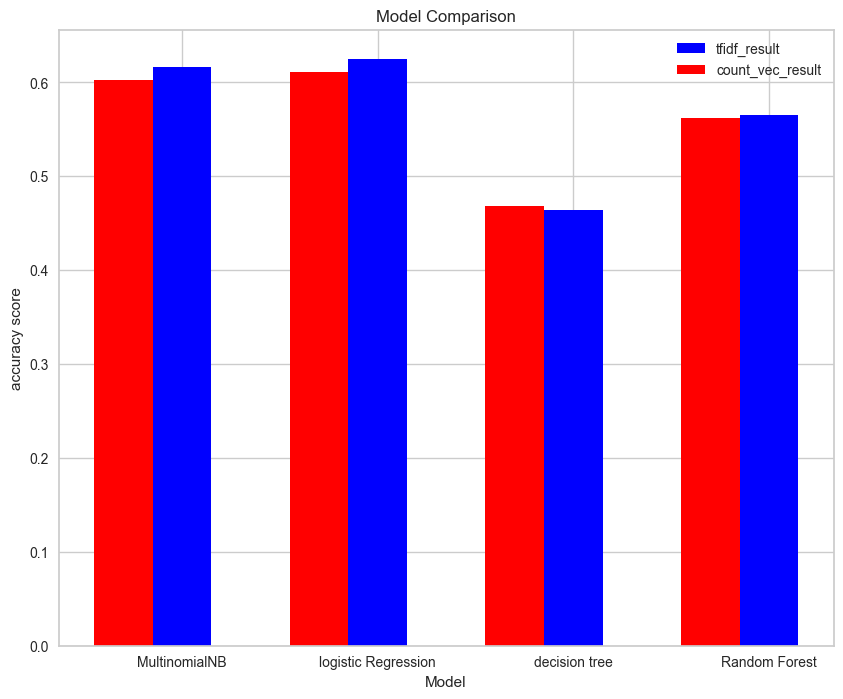

In [56]:
tfidf_result = pd.DataFrame(mrs.items(), columns=['model', 'accuracy_score'])
count_vec_result = pd.DataFrame(mrbsCV.items(), columns=['model','accuracy_score'])

y1 = tfidf_result['accuracy_score']
y2 = count_vec_result['accuracy_score']

plt.subplots(figsize=(10,8))
ind = np.arange(len(tfidf_result))

width = 0.3
plt.bar(ind, y1, width, color='blue')
plt.bar(ind - width, y2, width, color='red')

plt.title("Model Comparison")
plt.xlabel('Model')
plt.ylabel('accuracy score')
plt.xticks(np.arange(4), ['MultinomialNB','logistic Regression','decision tree','Random Forest'])
plt.legend(['tfidf_result','count_vec_result']);

In [57]:
# Merging the two tables
model_score = pd.merge(tfidf_result, count_vec_result, how='left', on='model')
model_score = model_score.rename(columns={'accuracy_score_x' : 'tfidf_result', 'accuracy_score_y':'count_vec_result'})


In [58]:
'''in this case Logistic regression more good result than others in both technique, then tdif more good
then select best parameter it'''

'''applying logistic regression model pipeline to test set'''

log_reg_pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,1), max_df=.85, min_df=15)),
                             ('clf', LogisticRegression(C=1.0, class_weight= None, multi_class='multinomial', penalty='l2', solver='lbfgs', random_state=42))])

log_reg_pipeline.fit(X_train, y_train)
y_pred_prob = log_reg_pipeline.predict_proba(X_test)
y_pred = log_reg_pipeline.predict(X_test)
print('Test accuracy score:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test accuracy score: 0.6369655172413793
              precision    recall  f1-score   support

         1.0       0.61      0.83      0.70      1491
         2.0       0.66      0.67      0.67      1095
         3.0       0.79      0.57      0.66       292
         4.0       0.68      0.41      0.51       275
         5.0       0.50      0.10      0.16       241
         6.0       0.56      0.17      0.26       231

    accuracy                           0.64      3625
   macro avg       0.63      0.46      0.49      3625
weighted avg       0.64      0.64      0.61      3625



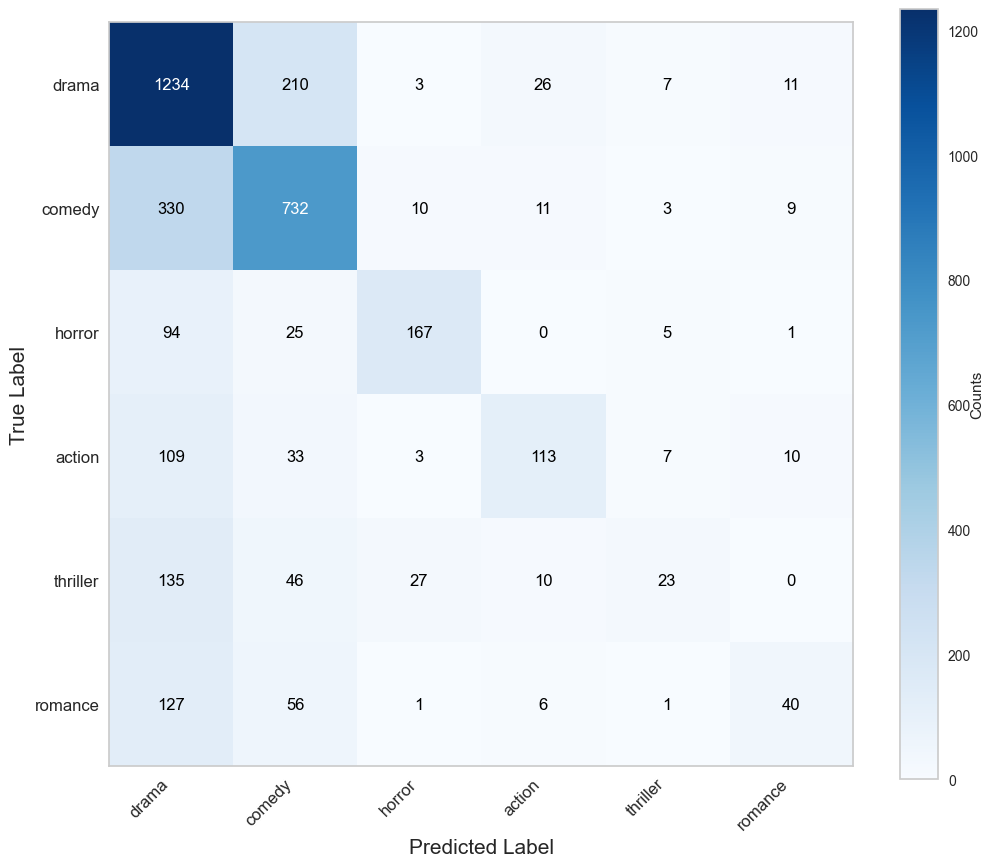

In [59]:
labels = ['drama','comedy','horror','action','thriller','romance']
cm = confusion_matrix(y_test, log_reg_pipeline.predict(X_test))

plt.figure(figsize=(12,10))
plt.imshow(cm, cmap='Blues')

# adding colobar
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts', rotation=90, va='bottom')

plt.xlabel('Predicted Label', size=15)
plt.ylabel('True Label', size=15)
plt.xticks(range(len(labels)), labels, size=12, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels, size=12)

#adding text annotation
thresh = cm.max() / 2
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j], ha ='center', va='center', color='white' if cm[i, j] > thresh else 'black')

plt.grid(None)
plt.show()



In [60]:
'''Calculating cosine similiarity between the genres based on words'''

genre_plot = [
    ['drama', ' '.join(list(set(drama_plot_list)))],
    ['comedy', ' '.join(list(set(comedy_plot_list)))],
    ['horror', ' '.join(list(set(horror_plot_list)))],
    ['action', ' '.join(list(set(action_plot_list)))],
    ['thriller', ' '.join(list(set(thriller_plot_list)))],
    ['romance', ' '.join(list(set(romance_plot_list)))]
]

genre_plot_df = pd.DataFrame(genre_plot, columns=['genre_type','plot_words'])
genre_plot_df

,genre_type,plot_words
0,drama,modification lighter vehicular sheshamma jos s...
1,comedy,modification lighter vehicular sgt tamilian to...
2,horror,trowel berating sgt tong yamauchi raglan galan...
3,action,trek hologram modification assure reservation ...
4,thriller,trek innard hologram modification unni maru as...
5,romance,punctured assure reservation jos periodically ...


In [61]:
count_vec = CountVectorizer()
count_metrix = count_vec.fit_transform(genre_plot_df['plot_words'])
consine_sim= pd.DataFrame(cosine_similarity(count_metrix))
consine_sim

,0,1,2,3,4,5
0,1.000000,0.572341,0.504951,0.490300,0.513298,0.464808
1,0.572341,1.000000,0.521843,0.497921,0.524141,0.462531
2,0.504951,0.521843,1.000000,0.516114,0.560012,0.478223
3,0.490300,0.497921,0.516114,1.000000,0.550045,0.517037
4,0.513298,0.524141,0.560012,0.550045,1.000000,0.524291
5,0.464808,0.462531,0.478223,0.517037,0.524291,1.000000
